In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis
The data export from Apple health is in XML format. Let's import it and look at some basic facts about this dataset.

In [2]:
df = pd.read_xml("apple_health_export/export.xml", xpath=".//Record[@type='HKQuantityTypeIdentifierStepCount']")

# Select the columns of interest
df = df[['value', 'startDate']]

# Rename columns for clarity
df.rename(columns={'value': 'step_count', 'startDate': 'date'}, inplace=True)

In [3]:
df.describe()

,step_count
count,36372.000000
mean,212.551166
std,248.832422
min,1.000000
25%,37.000000
50%,110.000000
75%,293.000000
max,1463.000000


In [4]:
df.head(5)

,step_count,date
0,66,2022-01-02 16:15:22 +0300
1,21,2022-01-02 16:30:01 +0300
2,15,2022-01-02 16:43:48 +0300
3,14,2022-01-02 16:55:02 +0300
4,16,2022-01-02 17:10:41 +0300


## Preprocessing
We need to aggregate step_counts for each day rather than keeping the timestamps.

In [5]:
# Preprocess so there is a single step count for each day.

df['date'] = pd.to_datetime(df['date'])
df = df.groupby(df['date'].dt.date).agg({'step_count': 'sum'}).reset_index()
df['date'] = pd.to_datetime(df['date'])

# Add the is_in_exam_period

EXAM_PERIOD_DATES = [
    ("2024-11-05", "2024-11-12"),
    ("2024-12-30", "2025-01-12"),
    ("2023-05-29", "2023-06-11"),
    ("2024-05-28", "2024-06-09"),
    ("2024-01-06", "2024-01-19"),
]

# Convert exam period dates to datetime
exam_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in EXAM_PERIOD_DATES]

# Define a function to check if a date is in any exam period
def is_in_exam_period(date):
    return any(start <= date <= end for start, end in exam_periods)

df['is_in_exam_period'] = df['date'].apply(is_in_exam_period)

In [6]:
df.head(5)

,date,step_count,is_in_exam_period
0,2022-01-02,132,False
1,2022-01-03,5100,False
2,2022-01-04,3607,False
3,2022-01-05,6803,False
4,2022-01-06,7293,False


In [7]:
df.describe()

,step_count
count,1099.000000
mean,7034.495905
std,4507.610293
min,132.000000
25%,3915.500000
50%,6350.000000
75%,9148.500000
max,29848.000000


## Plotting
Let's plot the data as a time series to spot unique features and trends.

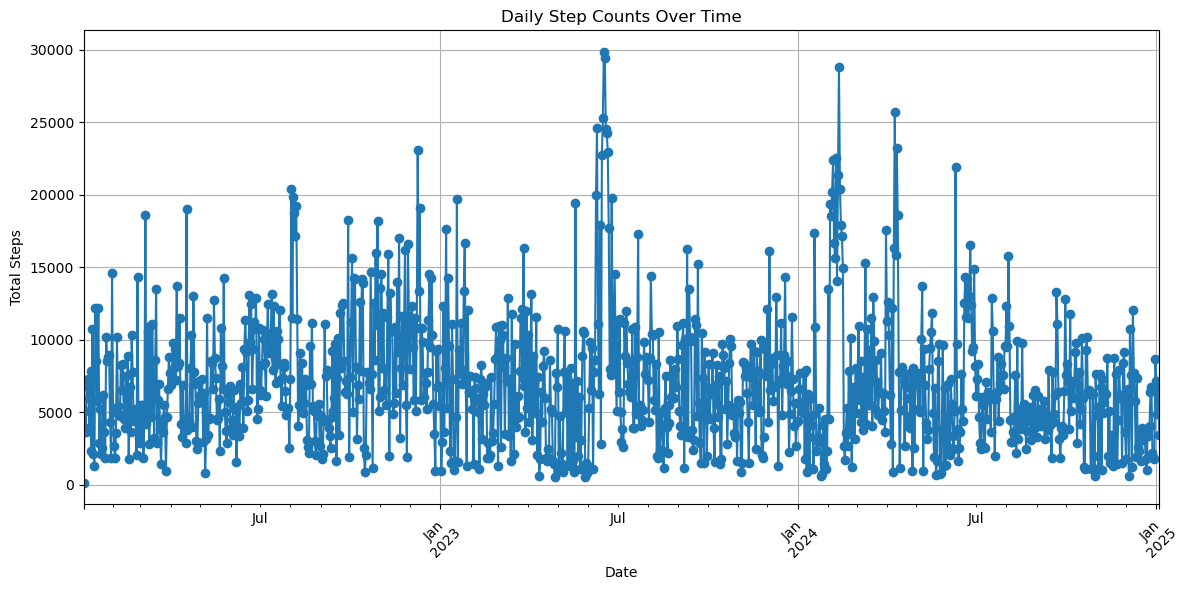

In [8]:
# Time series

df.set_index('date')['step_count'].plot(
    figsize=(12, 6),
    title="Daily Step Counts Over Time",
    xlabel="Date",
    ylabel="Total Steps",
    marker='o',
    grid=True
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

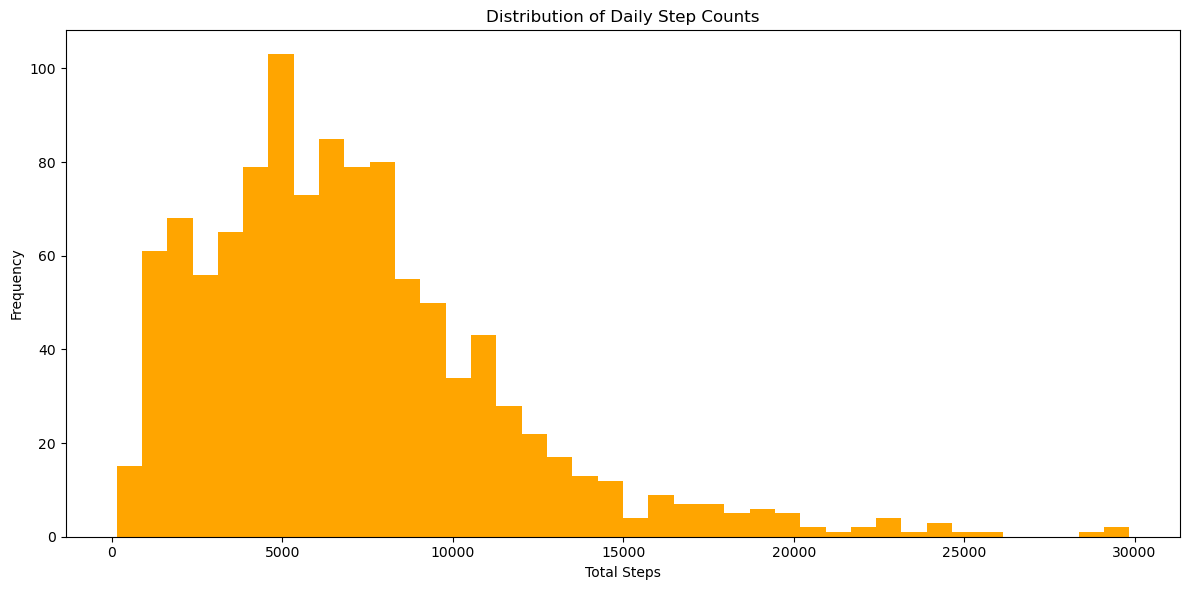

In [9]:
# Distribution

df['step_count'].plot(kind='hist', bins=40, figsize=(12, 6), title="Distribution of Daily Step Counts", color='orange')
plt.xlabel("Total Steps")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

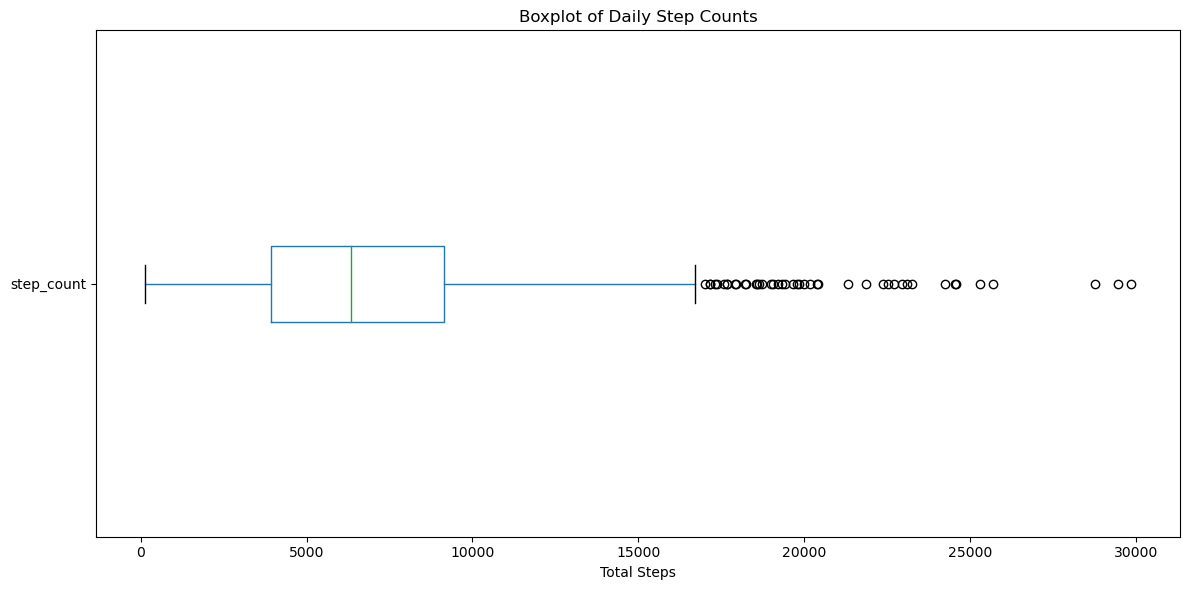

In [10]:
# Box plot for identifying outliers
def do_boxplot(df):
    df.boxplot(
        column='step_count',
        figsize=(12, 6),
        grid=False,
        vert=False
    )
    plt.title("Boxplot of Daily Step Counts")
    plt.xlabel("Total Steps")
    plt.tight_layout()
    plt.show()
do_boxplot(df)

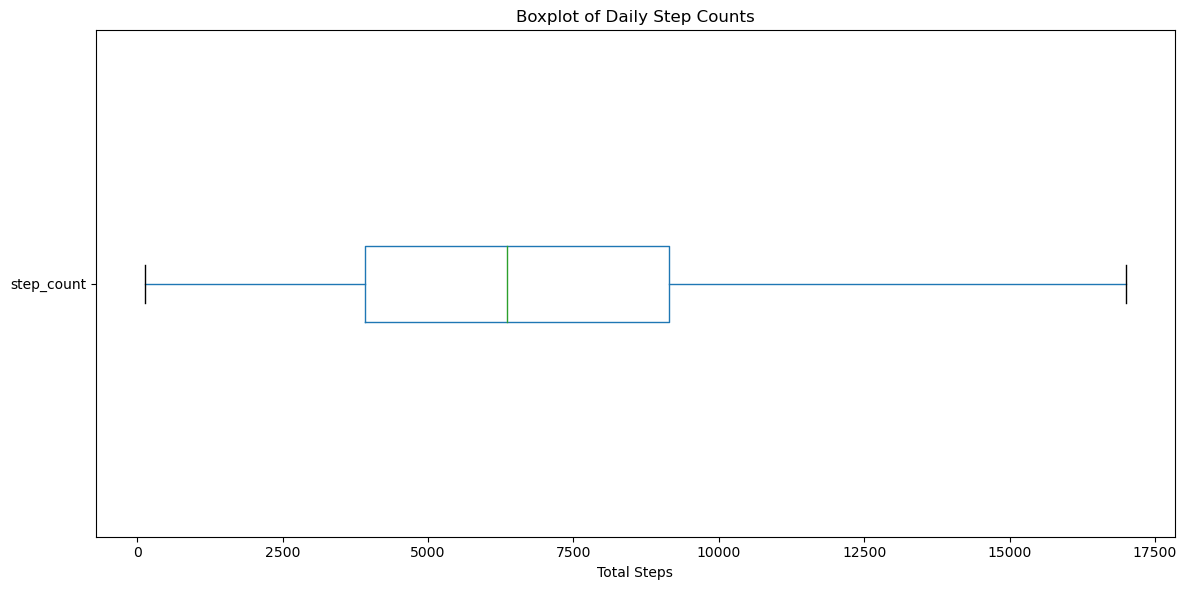

In [11]:
# Replace outliers with nearest bound
Q1 = df['step_count'].quantile(0.25)
Q3 = df['step_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (df['step_count'] < lower_bound) | (df['step_count'] > upper_bound)

df.loc[df['step_count'] < lower_bound, 'step_count'] = lower_bound
df.loc[df['step_count'] > upper_bound, 'step_count'] = upper_bound

do_boxplot(df)

In [12]:
df.describe()

,step_count
count,1099.000000
mean,6882.757052
std,4030.542410
min,132.000000
25%,3915.500000
50%,6350.000000
75%,9148.500000
max,16998.000000


## Periodic Trends
Let's investigate the weekly, monthly and yearly trends.

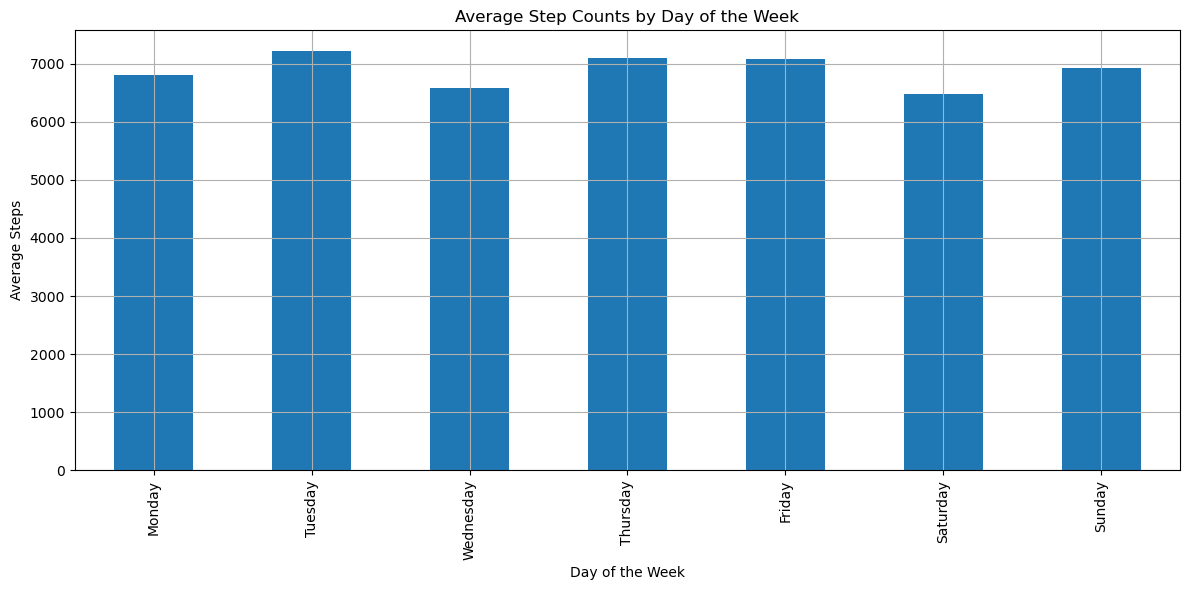

In [13]:
# Add a column for the day of the week
df['day_of_week'] = df['date'].dt.day_name()

# Calculate the average step count for each day of the week
weekly_trends = df.groupby('day_of_week')['step_count'].mean()

# Reorder the days for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_trends = weekly_trends.reindex(days_order)

# Plot the weekly trends
weekly_trends.plot(
    kind='bar',
    figsize=(12, 6),
    title="Average Step Counts by Day of the Week",
    xlabel="Day of the Week",
    ylabel="Average Steps",
    grid=True
)
plt.tight_layout()
plt.show()

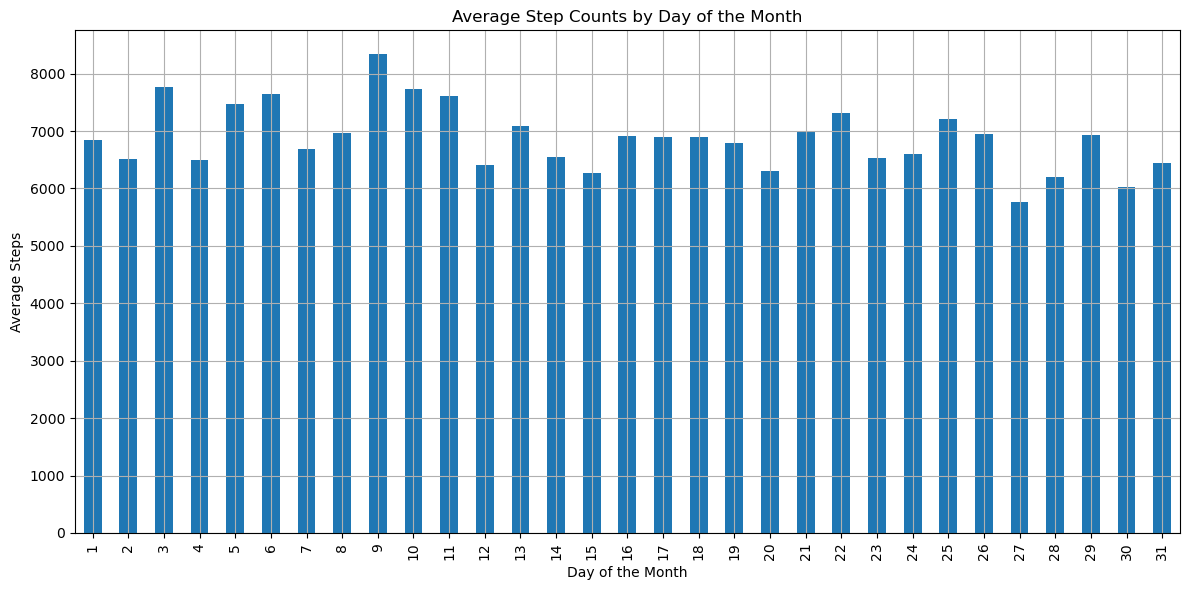

In [14]:
# Add a column for the day of the month
df['day_of_month'] = df['date'].dt.day

# Calculate the average step count for each day of the month
daily_trends = df.groupby('day_of_month')['step_count'].mean()

# Plot the trends
daily_trends.plot(
    kind='bar',
    figsize=(12, 6),
    title="Average Step Counts by Day of the Month",
    xlabel="Day of the Month",
    ylabel="Average Steps",
    grid=True
)
plt.tight_layout()
plt.show()


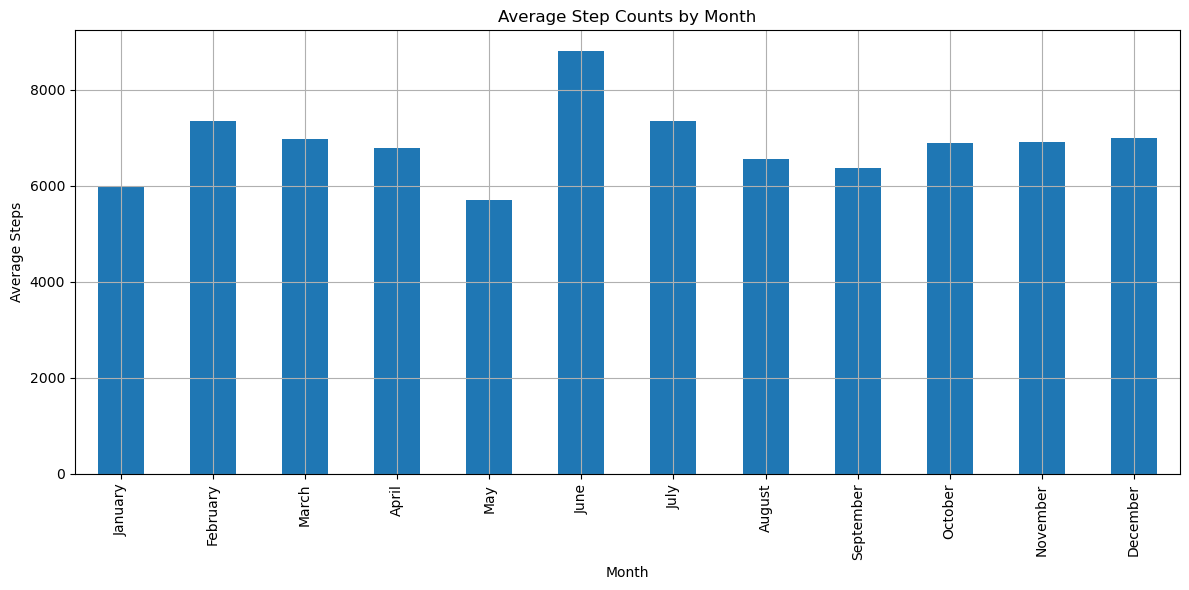

In [15]:
# Add a column for the month
df['month'] = df['date'].dt.month_name()

# Calculate the average step count for each month
monthly_trends = df.groupby('month')['step_count'].mean()

# Reorder the months for better visualization
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_trends = monthly_trends.reindex(months_order)

# Plot the monthly trends
monthly_trends.plot(
    kind='bar',
    figsize=(12, 6),
    title="Average Step Counts by Month",
    xlabel="Month",
    ylabel="Average Steps",
    grid=True
)
plt.tight_layout()
plt.show()

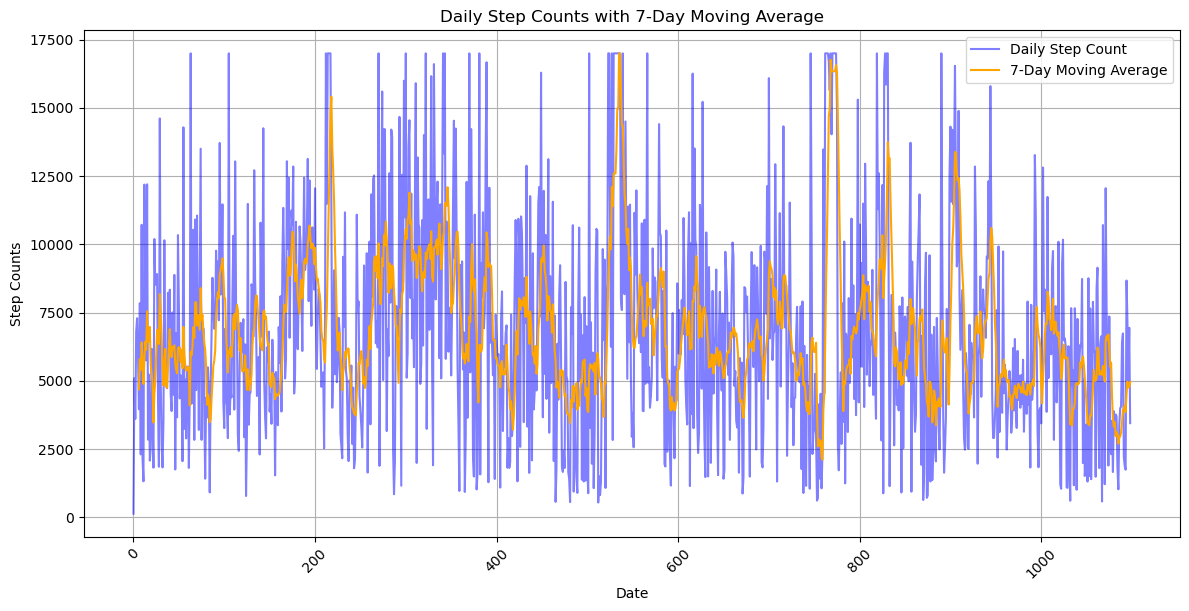

In [16]:
# Calculate the 7-day moving average
df['7_day_moving_avg'] = df['step_count'].rolling(window=7).mean()

# Plot the original step counts and the 7-day moving average
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['step_count'], label='Daily Step Count', alpha=0.5, linestyle='-', color='blue')
plt.plot(df.index, df['7_day_moving_avg'], label='7-Day Moving Average', linestyle='-', color='orange')

# Customize the plot
plt.title("Daily Step Counts with 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Step Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


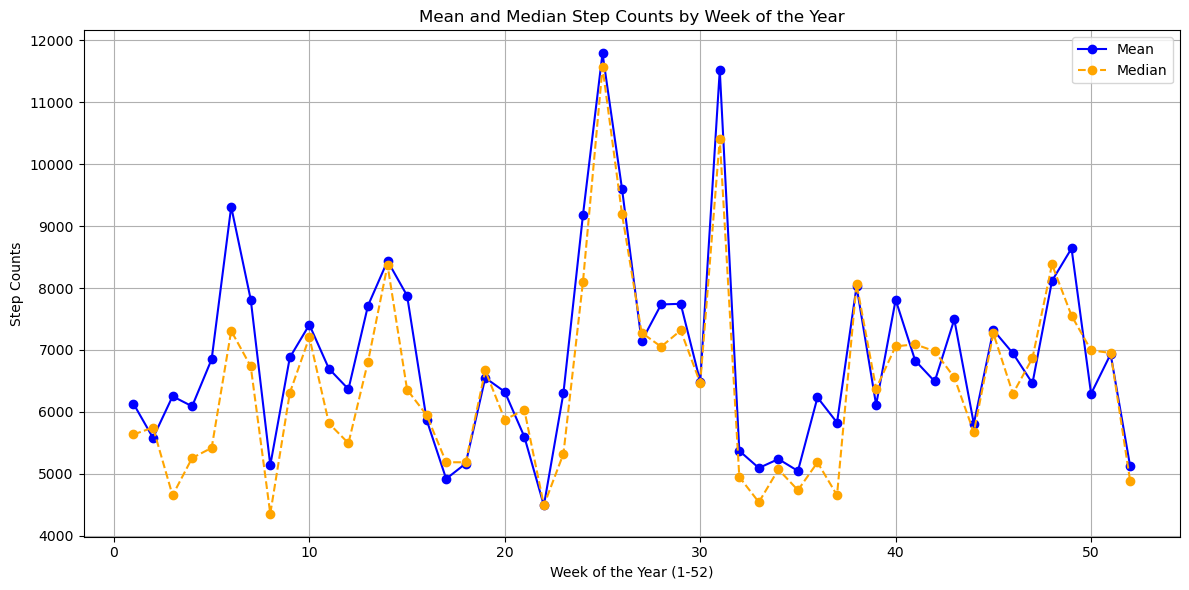

In [17]:
# Weekly time series

df['week_of_year'] = df['date'].dt.isocalendar().week

# Calculate the mean and median step counts for each week of the year
weekly_stats = df.groupby('week_of_year')['step_count'].agg(['mean', 'median']).reset_index()

# Plot the trends
plt.figure(figsize=(12, 6))
plt.plot(weekly_stats['week_of_year'], weekly_stats['mean'], marker='o', label='Mean', linestyle='-', color='blue')
plt.plot(weekly_stats['week_of_year'], weekly_stats['median'], marker='o', label='Median', linestyle='--', color='orange')

# Customize the plot
plt.title("Mean and Median Step Counts by Week of the Year")
plt.xlabel("Week of the Year (1-52)")
plt.ylabel("Step Counts")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


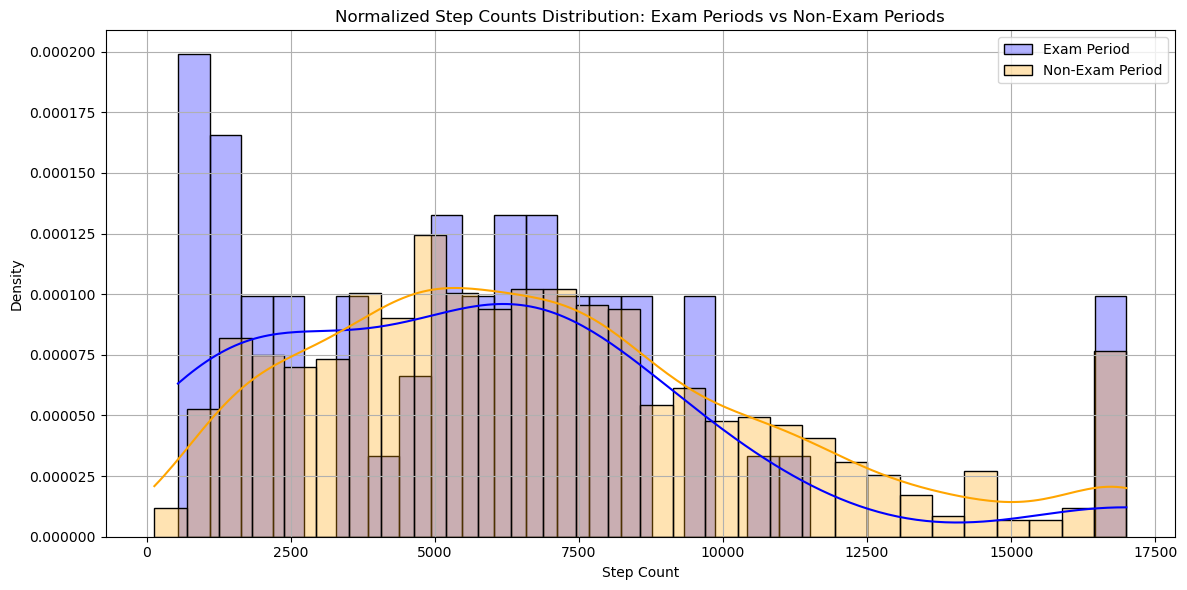

In [18]:
# Split the data into exam and non-exam periods
exam_period_data = df[df['is_in_exam_period']]
non_exam_period_data = df[~df['is_in_exam_period']]

# Create the plot
plt.figure(figsize=(12, 6))

# Add normalized histograms with KDE
sns.histplot(exam_period_data['step_count'], label='Exam Period', bins=30, kde=True, color='blue', alpha=0.3, stat='density')
sns.histplot(non_exam_period_data['step_count'], label='Non-Exam Period', bins=30, kde=True, color='orange', alpha=0.3, stat='density')

# Customize the plot
plt.title("Normalized Step Counts Distribution: Exam Periods vs Non-Exam Periods")
plt.xlabel("Step Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


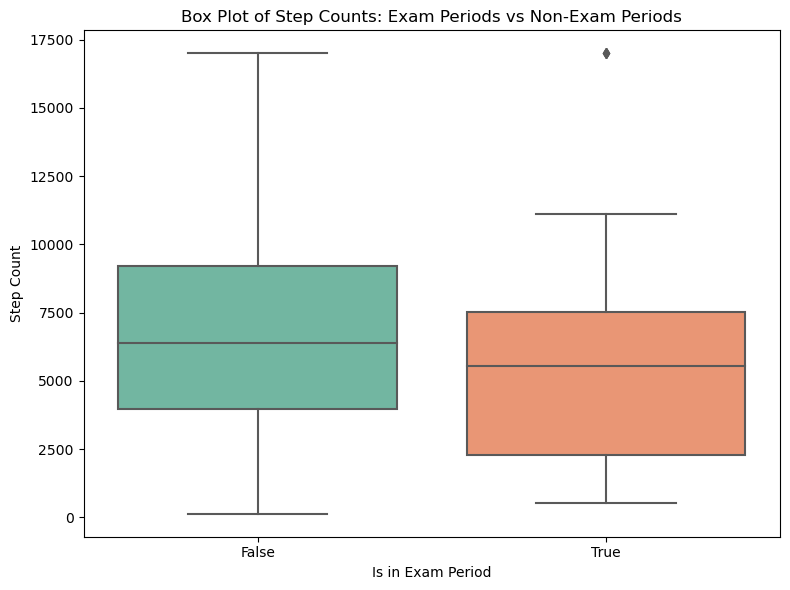

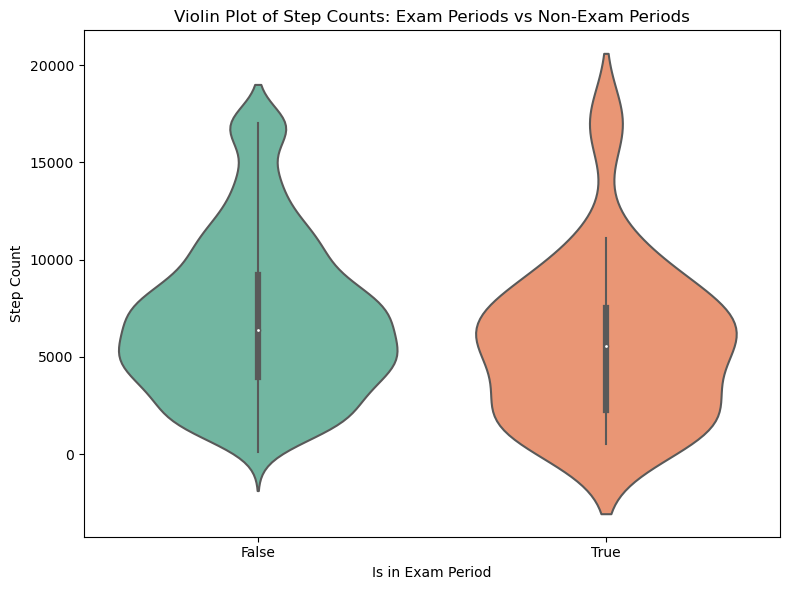

In [19]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_in_exam_period', y='step_count', data=df, palette='Set2')
plt.title("Box Plot of Step Counts: Exam Periods vs Non-Exam Periods")
plt.xlabel("Is in Exam Period")
plt.ylabel("Step Count")
plt.tight_layout()
plt.show()

# Violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='is_in_exam_period', y='step_count', data=df, palette='Set2', split=True)
plt.title("Violin Plot of Step Counts: Exam Periods vs Non-Exam Periods")
plt.xlabel("Is in Exam Period")
plt.ylabel("Step Count")
plt.tight_layout()
plt.show()

# Augmentation

We will now augment this dataset with weather data to control for this.

In [20]:
# Find out the date range

df.head(2)

,date,step_count,is_in_exam_period,day_of_week,day_of_month,month,7_day_moving_avg,week_of_year
0,2022-01-02,132,False,Sunday,2,January,NaN,52
1,2022-01-03,5100,False,Monday,3,January,NaN,1


In [21]:
df.tail(2)

,date,step_count,is_in_exam_period,day_of_week,day_of_month,month,7_day_moving_avg,week_of_year
1097,2025-01-03,6944,True,Friday,3,January,4782.714286,1
1098,2025-01-04,3449,True,Saturday,4,January,4959.000000,1


In [22]:
# import requests

# # Define parameters
# latitude = 41.0082
# longitude = 28.9784
# start_date = '2022-01-02'
# end_date = '2025-01-04'
# timezone = 'Europe/Moscow'
# url = (
#     f'https://archive-api.open-meteo.com/v1/archive?'
#     f'latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&'
#     'daily=temperature_2m_max,temperature_2m_min,precipitation_sum&'
#     f'timezone={timezone}'
# )

# # Make the API request
# response = requests.get(url)
# data = response.json()

# # Extract relevant data
# weather_data = {
#     'date': data['daily']['time'],
#     'temp_max': data['daily']['temperature_2m_max'],
#     'temp_min': data['daily']['temperature_2m_min'],
#     'precipitation': data['daily']['precipitation_sum']
# }

# # Create a DataFrame
# weather_df = pd.DataFrame(weather_data)
# weather_df['date'] = pd.to_datetime(weather_df['date'])

# # Display the DataFrame
# weather_df.head()

# weather_df.to_csv("weather.csv")

weather_df = pd.read_csv("weather.csv")
weather_df['date'] = pd.to_datetime(weather_df['date'])


# Calculate the "average" temperature
weather_df['avg_temp'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2

# Drop 'Unnamed: 0' column
weather_df = weather_df.drop(columns=['Unnamed: 0', 'temp_max', 'temp_min'])

# Set 'date' as the index
weather_df = weather_df.set_index('date')

weather_df.head()

,precipitation,avg_temp
date,,
2022-01-02,0.9,8.50
2022-01-03,0.0,7.80
2022-01-04,0.0,10.10
2022-01-05,0.0,12.85
2022-01-06,0.0,14.40


In [23]:
df_with_weather = pd.merge(df, weather_df, on='date', how='left')
df_with_weather.head()

,date,step_count,is_in_exam_period,day_of_week,day_of_month,month,7_day_moving_avg,week_of_year,precipitation,avg_temp
0,2022-01-02,132,False,Sunday,2,January,NaN,52,0.9,8.50
1,2022-01-03,5100,False,Monday,3,January,NaN,1,0.0,7.80
2,2022-01-04,3607,False,Tuesday,4,January,NaN,1,0.0,10.10
3,2022-01-05,6803,False,Wednesday,5,January,NaN,1,0.0,12.85
4,2022-01-06,7293,False,Thursday,6,January,NaN,1,0.0,14.40


In [24]:
df_with_weather.corr()

/var/folders/kh/ns__nnv95b3_rg_4l5kkrrrr0000gn/T/ipykernel_68829/531737433.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_with_weather.corr()


,step_count,is_in_exam_period,day_of_month,7_day_moving_avg,week_of_year,precipitation,avg_temp
step_count,1.000000,-0.068640,-0.060445,0.550024,0.010888,-0.055759,0.068717
is_in_exam_period,-0.068640,1.000000,-0.109075,-0.178372,-0.122759,-0.023633,-0.021843
day_of_month,-0.060445,-0.109075,1.000000,-0.044568,0.078715,-0.007159,-0.004462
7_day_moving_avg,0.550024,-0.178372,-0.044568,1.000000,0.039376,-0.051728,0.097567
week_of_year,0.010888,-0.122759,0.078715,0.039376,1.000000,0.003250,0.364174
precipitation,-0.055759,-0.023633,-0.007159,-0.051728,0.003250,1.000000,-0.151171
avg_temp,0.068717,-0.021843,-0.004462,0.097567,0.364174,-0.151171,1.000000


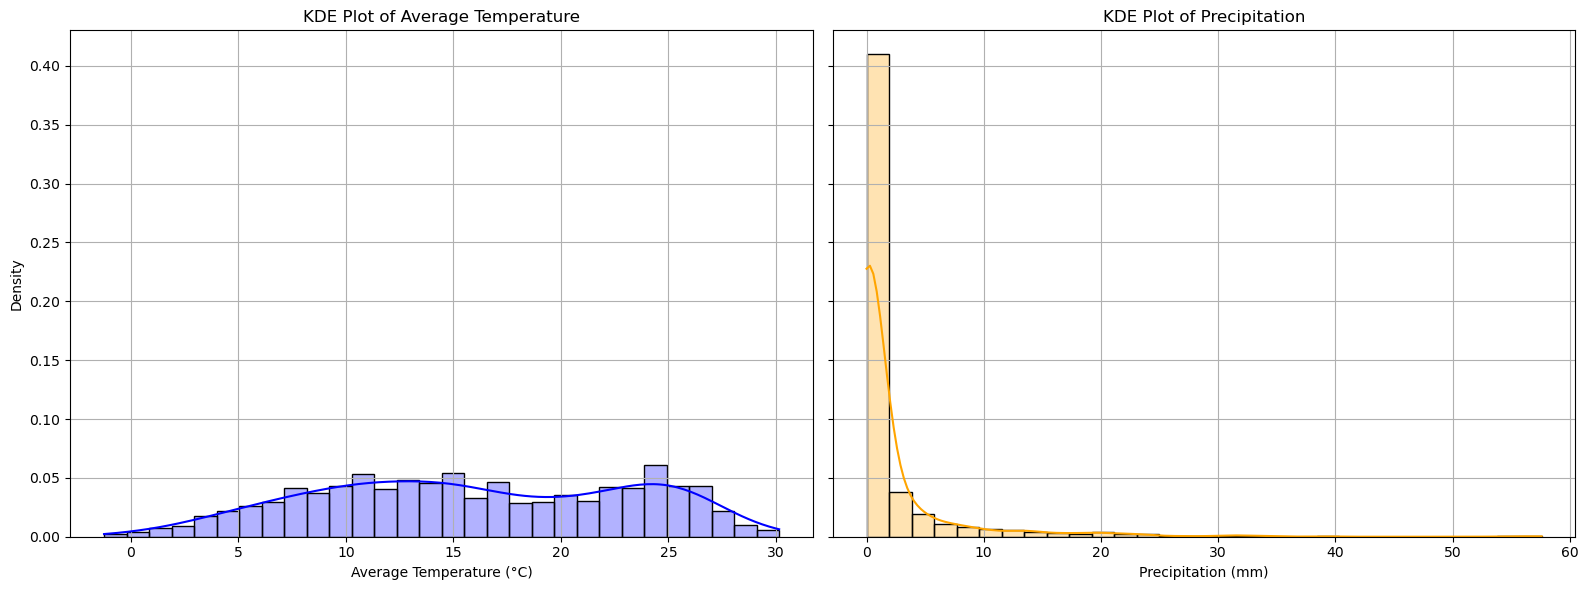

In [25]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# KDE and histogram for average temperature
sns.histplot(df_with_weather['avg_temp'], bins=30, kde=True, color='blue', alpha=0.3, stat='density', ax=axes[0])
axes[0].set_title("KDE Plot of Average Temperature")
axes[0].set_xlabel("Average Temperature (°C)")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# KDE and histogram for precipitation
sns.histplot(df_with_weather['precipitation'], bins=30, kde=True, color='orange', alpha=0.3, stat='density', ax=axes[1])
axes[1].set_title("KDE Plot of Precipitation")
axes[1].set_xlabel("Precipitation (mm)")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


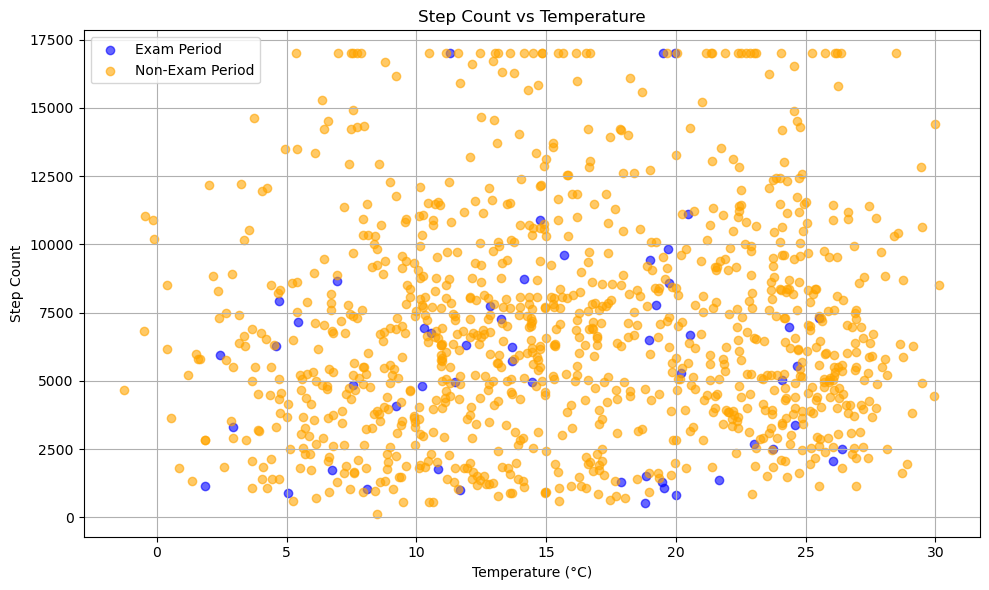

In [26]:
# Scatter plot for step count vs temperature
plt.figure(figsize=(10, 6))


# Plot exam and non-exam periods with different colors
plt.scatter(df_with_weather[df_with_weather['is_in_exam_period']]['avg_temp'], 
            df_with_weather[df_with_weather['is_in_exam_period']]['step_count'], 
            alpha=0.6, label='Exam Period', color='blue')
plt.scatter(df_with_weather[~df_with_weather['is_in_exam_period']]['avg_temp'], 
            df_with_weather[~df_with_weather['is_in_exam_period']]['step_count'], 
            alpha=0.6, label='Non-Exam Period', color='orange')

# Customize the plot
plt.title("Step Count vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Step Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

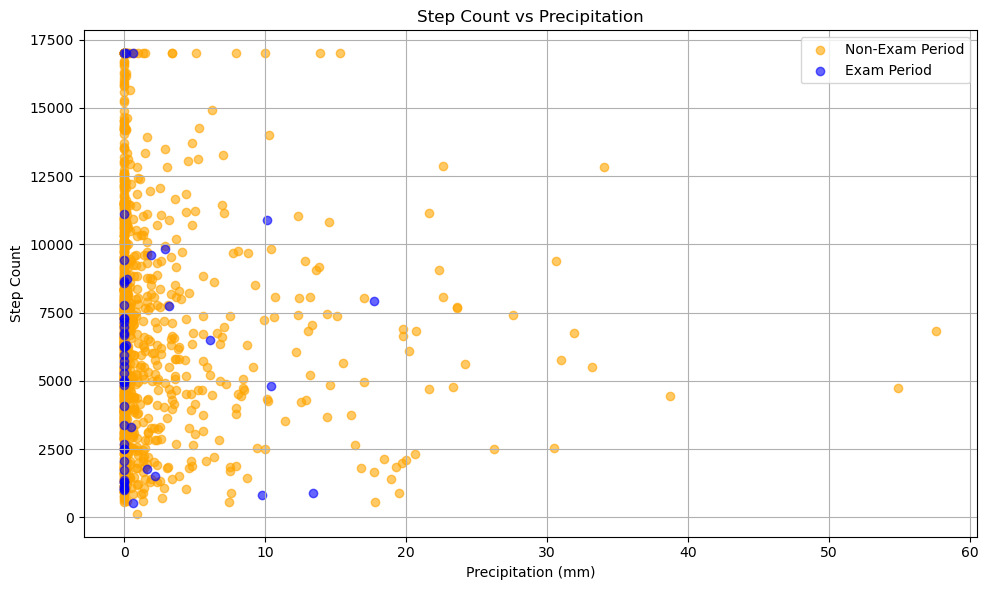

In [27]:
# Scatter plot for step count vs temperature
plt.figure(figsize=(10, 6))


# Plot exam and non-exam periods with different colors

plt.scatter(df_with_weather[~df_with_weather['is_in_exam_period']]['precipitation'], 
            df_with_weather[~df_with_weather['is_in_exam_period']]['step_count'], 
            alpha=0.6, label='Non-Exam Period', color='orange')
plt.scatter(df_with_weather[df_with_weather['is_in_exam_period']]['precipitation'], 
            df_with_weather[df_with_weather['is_in_exam_period']]['step_count'], 
            alpha=0.6, label='Exam Period', color='blue')

# Customize the plot
plt.title("Step Count vs Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Step Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictors

We will train a naive bayes classifier to predict whether the step count for the day is "healthy" (above or equal to 10_000) and how this variable relates to `is_in_exam_period`.

More formally, we aim to find probabilities:
$$
P(\texttt{healthy} | \texttt{is_in_exam_period})\\
P(\texttt{healthy} | \lnot \texttt{is_in_exam_period})\\
$$

First, we will verify the Gaussian hypothesis, that is that these variables are independent.

In [28]:
df_with_weather["healthy"] = df_with_weather["step_count"] >= 10_000

In [29]:
from sklearn.feature_selection import mutual_info_classif

correlation = df_with_weather['is_in_exam_period'].corr(df_with_weather['healthy'])
print(f"Correlation: {correlation * 100:.2f}%")

X = df_with_weather[['is_in_exam_period']]
y = df_with_weather['healthy']
mi_score = mutual_info_classif(X, y)
print(f"Mutual Information Score: {mi_score[0]:.5f}")

Correlation: -6.35%
Mutual Information Score: 0.00000


Clearly there is no significant linear correlation between these variables. Furthermore, the mutual information score close to 0 suggests that these variables are independent. Thus the Gaussian hypothesis is true in this case.

In [30]:
# Select features for Bayesian Network
features = ['healthy', 'is_in_exam_period', 'precipitation', 'avg_temp', 
            'day_of_week', 'day_of_month', 'month', 'week_of_year']
df_bn = df_with_weather[features]
df_bn.head()

,healthy,is_in_exam_period,precipitation,avg_temp,day_of_week,day_of_month,month,week_of_year
0,False,False,0.9,8.50,Sunday,2,January,52
1,False,False,0.0,7.80,Monday,3,January,1
2,False,False,0.0,10.10,Tuesday,4,January,1
3,False,False,0.0,12.85,Wednesday,5,January,1
4,False,False,0.0,14.40,Thursday,6,January,1


In [31]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Define the structure of the Bayesian Network
# Example structure: is_in_exam_period → healthy
model = BayesianNetwork([
    ('is_in_exam_period', 'healthy'),
    ('precipitation', 'healthy'),
    ('avg_temp', 'healthy'),
    ('day_of_week', 'healthy')
])

# Learn CPDs using Maximum Likelihood Estimation
model.fit(df_bn, estimator=MaximumLikelihoodEstimator)

In [32]:
# Create an inference object
inference = VariableElimination(model)

# Query P(healthy | is_in_exam_period = 1)
healthy_given_exam = inference.query(variables=['healthy'], evidence={'is_in_exam_period': 1})
print("P(healthy | is_in_exam_period = 1):")
print(healthy_given_exam)

# Query P(healthy | is_in_exam_period = 0)
healthy_given_not_exam = inference.query(variables=['healthy'], evidence={'is_in_exam_period': 0})
print("P(healthy | is_in_exam_period = 0):")
print(healthy_given_not_exam)

P(healthy | is_in_exam_period = 1):
+----------------+----------------+
| healthy        |   phi(healthy) |
+================+================+
| healthy(False) |         0.5034 |
+----------------+----------------+
| healthy(True)  |         0.4966 |
+----------------+----------------+
P(healthy | is_in_exam_period = 0):
+----------------+----------------+
| healthy        |   phi(healthy) |
+================+================+
| healthy(False) |         0.5230 |
+----------------+----------------+
| healthy(True)  |         0.4770 |
+----------------+----------------+


Thus according to the data, the likelihood of having a healthy step count (above $10,000$) increases by around $2$% when it is not an exam week.